# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

# Wrangling the Data

In [2]:
df = pd.read_excel("Season_Stats.xlsx")

In [3]:
desired_columns = ['Season', '3PA']

In [4]:
df = df[desired_columns]

In [5]:
df = df.dropna()

In [6]:
df.set_index('Season', inplace=True)

In [7]:
df.sort_index(ascending=True, inplace=True)

In [8]:
cleaned_data = torch.from_numpy(df.to_numpy())

In [9]:
cleaned_data = cleaned_data.type(torch.float32)

In [10]:
cleaned_data.dtype

torch.float32

In [11]:
cleaned_data

tensor([[ 2.8000],
        [ 2.0000],
        [ 2.3000],
        [ 2.3000],
        [ 2.4000],
        [ 3.1000],
        [ 3.3000],
        [ 4.7000],
        [ 5.0000],
        [ 6.6000],
        [ 6.6000],
        [ 7.1000],
        [ 7.6000],
        [ 9.0000],
        [ 9.9000],
        [15.3000],
        [16.0000],
        [16.8000],
        [12.7000],
        [13.2000],
        [13.7000],
        [13.7000],
        [14.7000],
        [14.7000],
        [14.9000],
        [15.8000],
        [16.0000],
        [16.9000],
        [18.1000],
        [18.1000],
        [18.1000],
        [18.0000],
        [18.4000],
        [20.0000],
        [21.5000],
        [22.4000],
        [24.1000],
        [27.0000],
        [29.0000],
        [32.0000],
        [34.1000],
        [34.6000],
        [35.2000],
        [34.2000]])

# Splitting the data

In [12]:
train_dataset, validation_dataset = train_test_split(cleaned_data, test_size=0.3, shuffle=False)

# Creating the Model

In [13]:
class LSTM_MODEL(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super().__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(self.input_size, self.hidden_size, self.num_layers)
        self.linear1 = nn.Linear(self.hidden_size, 64)
        self.linear2 = nn.Linear(64, 1)

    def forward(self, X):
        X, hidden = self.lstm(X)
        X = self.linear1(X)
        X = self.linear2(X)

        return X, hidden

In [14]:
input_size = 1
num_hidden = 128
num_layers = 1
batchsize = 1
seqlength = 4
N = len(train_dataset)

model = LSTM_MODEL(input_size,num_hidden,num_layers)

In [15]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training the Model

In [16]:
epochs = 200
training_losses = np.zeros(epochs)
validation_losses = np.zeros(epochs)

for i in range(epochs):

    segtrainlosses = []
    segvalidationloss = []
    H = torch.zeros(num_layers,batchsize,num_hidden)
    C = torch.zeros(num_layers,batchsize,num_hidden)
    hidden_inputs = (H,C)

    for timei in range(N-seqlength):

        #grabbing a snippet of data
        X_train = train_dataset[timei:timei+seqlength].view(seqlength,batchsize,-1)
        y_train = train_dataset[timei+seqlength].view(1,1)

        #forward the data
        predictions, hidden_inputs = model.forward(X_train)

        #loss
        predicted_value = predictions[-1]
        loss = criterion(predicted_value,y_train)

        #backpropagation and gradient descent
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #loss from the segment
        segtrainlosses.append(loss)

    #validation dataset
    model.eval()
    with torch.no_grad():
        for timei in range(len(validation_dataset) - seqlength):
                X_validation = validation_dataset[timei:timei+seqlength].view(seqlength,batchsize,-1)
                y_validation = validation_dataset[timei+seqlength].view(1,1)
                predictions, hidden_inputs = model.forward(X_validation)
                val_predicted_value = predictions[-1]
                validation_loss = criterion(val_predicted_value,y_validation)
                segvalidationloss.append(validation_loss)


    training_losses[i] = np.mean([loss.detach().numpy() for loss in segtrainlosses])
    validation_losses[i] = np.mean([loss.detach().numpy() for loss in segvalidationloss])

    if i%10 == 0:
         print(f'EPOCH: {i} Training Loss: {training_losses[i].item()} Validation Loss: {validation_losses[i].item()}')


EPOCH: 0 Training Loss: 73.4717025756836 Validation Loss: 340.9306640625
EPOCH: 10 Training Loss: 3.6551434993743896 Validation Loss: 187.7351837158203
EPOCH: 20 Training Loss: 3.440446138381958 Validation Loss: 174.40623474121094
EPOCH: 30 Training Loss: 3.2034718990325928 Validation Loss: 162.81210327148438
EPOCH: 40 Training Loss: 2.96647310256958 Validation Loss: 151.3909454345703
EPOCH: 50 Training Loss: 2.731501579284668 Validation Loss: 139.9297332763672
EPOCH: 60 Training Loss: 2.539181709289551 Validation Loss: 130.49603271484375
EPOCH: 70 Training Loss: 2.391540765762329 Validation Loss: 123.82173919677734
EPOCH: 80 Training Loss: 2.285815954208374 Validation Loss: 119.53265380859375
EPOCH: 90 Training Loss: 2.2055916786193848 Validation Loss: 116.71895599365234
EPOCH: 100 Training Loss: 2.139282464981079 Validation Loss: 114.89588928222656
EPOCH: 110 Training Loss: 2.0926711559295654 Validation Loss: 116.7479248046875
EPOCH: 120 Training Loss: 1.7891433238983154 Validation L

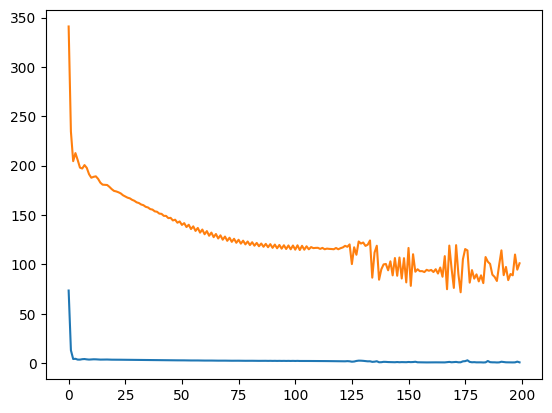

In [17]:
plt.plot(training_losses)
plt.plot(validation_losses)

# Next Steps: Investigate high variance issue!